In [176]:
# import all necessary libraries
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import f_classif, mutual_info_classif

from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, auc

In [186]:
data = pd.read_csv('train.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   client_id         73799 non-null  int64 
 1   education         73492 non-null  object
 2   sex               73799 non-null  object
 3   age               73799 non-null  int64 
 4   car               73799 non-null  object
 5   car_type          73799 non-null  object
 6   decline_app_cnt   73799 non-null  int64 
 7   good_work         73799 non-null  int64 
 8   bki_request_cnt   73799 non-null  int64 
 9   home_address      73799 non-null  int64 
 10  work_address      73799 non-null  int64 
 11  income            73799 non-null  int64 
 12  foreign_passport  73799 non-null  object
 13  default           73799 non-null  int64 
dtypes: int64(9), object(5)
memory usage: 7.9+ MB


In [192]:
data.groupby('education').income.describe()

,count,mean,std,min,25%,50%,75%,max
education,,,,,,,,
ACD,194.0,82966.634021,82996.490589,3073.0,30000.0,60000.0,100000.0,500000.0
GRD,23365.0,54663.948941,59108.701060,2000.0,25000.0,40000.0,60000.0,1000000.0
PGR,1257.0,77548.206046,76649.747530,5000.0,35000.0,60000.0,90000.0,1000000.0
SCH,38860.0,31960.275039,32780.593615,1000.0,17000.0,25000.0,38000.0,1000000.0
UGR,9816.0,39391.796251,37995.676321,1000.0,20000.0,30000.0,45000.0,950000.0


In [195]:
data.groupby('good_work').education.count()

good_work
0    61370
1    12122
Name: education, dtype: int64

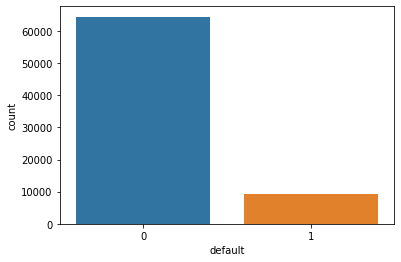

In [118]:
sns.countplot(data=data, x='default');

We can see more clients without default.

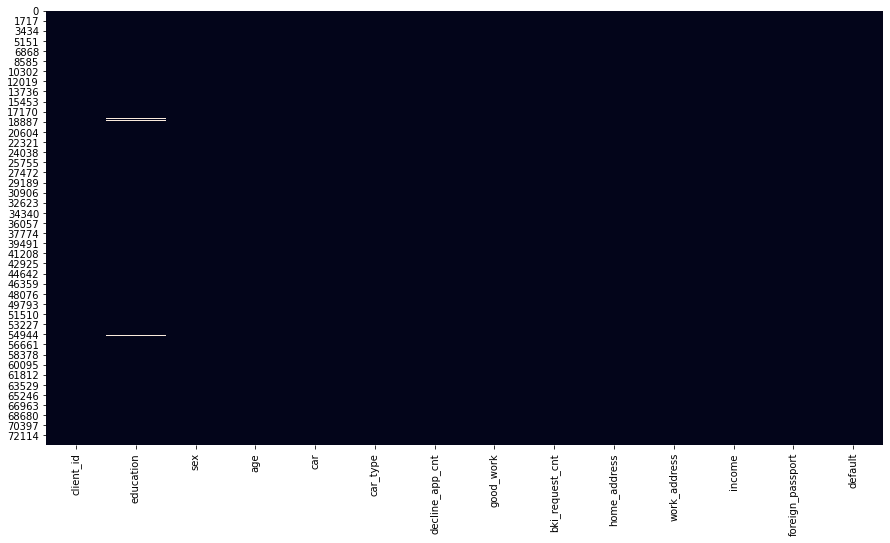

In [119]:
# find the missing values
plt.figure(figsize=(15, 8))
sns.heatmap(annot=False, data=data.isna(), cbar=False);

In [120]:
data.isna().sum()

client_id             0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
bki_request_cnt       0
home_address          0
work_address          0
income                0
foreign_passport      0
default               0
dtype: int64

Only one feature has missing values, education. Let's look in more details on the values of this feature.

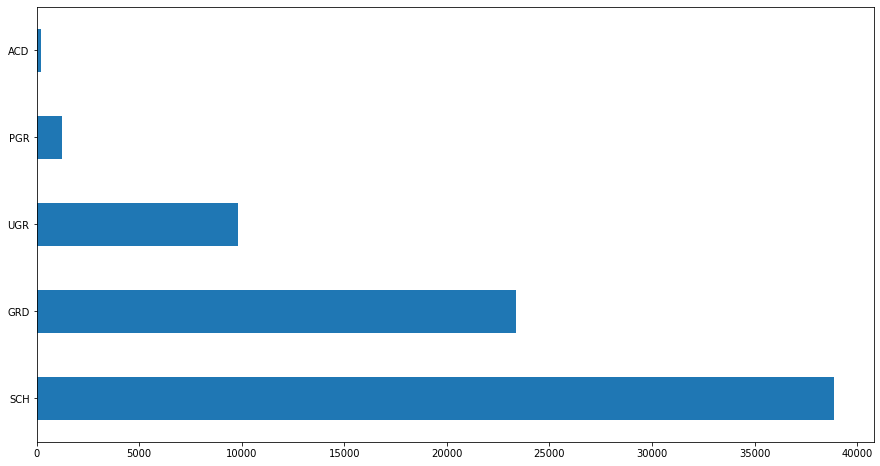

In [121]:
plt.figure(figsize=(15, 8))
data.education.value_counts().plot(kind='barh');

Fill the missing values with the most often present education value: 'SCH'.

In [122]:
data.fillna(value=data.education.value_counts().index[0], axis=0, inplace=True)
data.isna().sum()

client_id           0
education           0
sex                 0
age                 0
car                 0
car_type            0
decline_app_cnt     0
good_work           0
bki_request_cnt     0
home_address        0
work_address        0
income              0
foreign_passport    0
default             0
dtype: int64

Let's split all existing in the dataset columns into biniry, categorical and numerical.

In [123]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['education', 'home_address', 'work_address']
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']

### Numerical features

Let's look at the disribution of numerical columns.

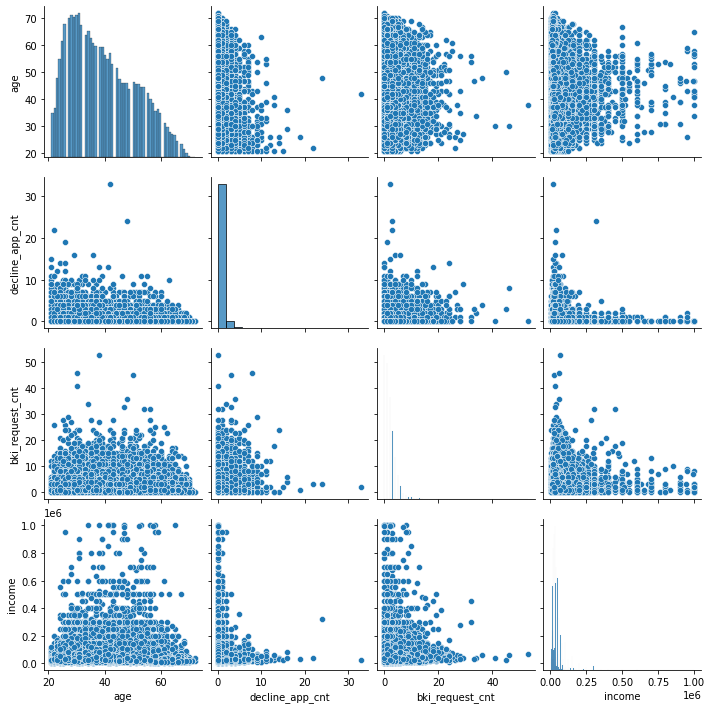

In [124]:
sns.pairplot(data[num_cols])

Especially for 3 out of 4 features we see a right-skewed distribution far from the normal one. Let's log transform the data that can help in this case. 

<Figure size 432x288 with 0 Axes>

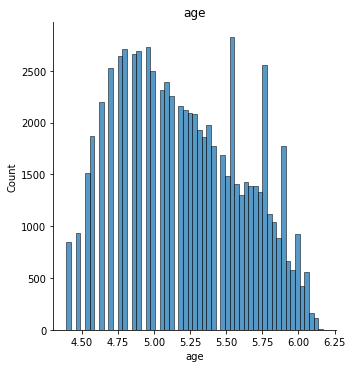

<Figure size 432x288 with 0 Axes>

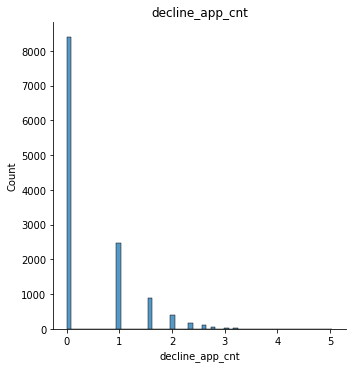

<Figure size 432x288 with 0 Axes>

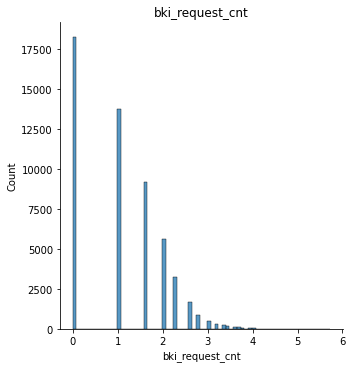

<Figure size 432x288 with 0 Axes>

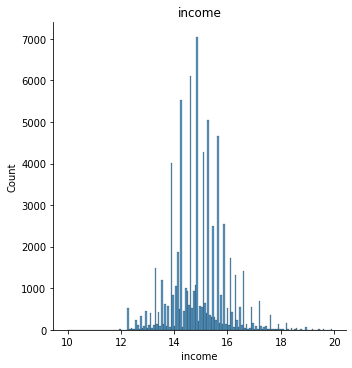

In [181]:
for i in num_cols:
    plt.figure();
    sns.displot(np.log2(data[i][data[i] > 0]).dropna(), kde = False, rug=False);
    plt.title(i);
    plt.show();

We can observe that log transformation didn't help in the current case. 

To analyze the numerical columns, let's look how numerical features have an influence on the target feature.

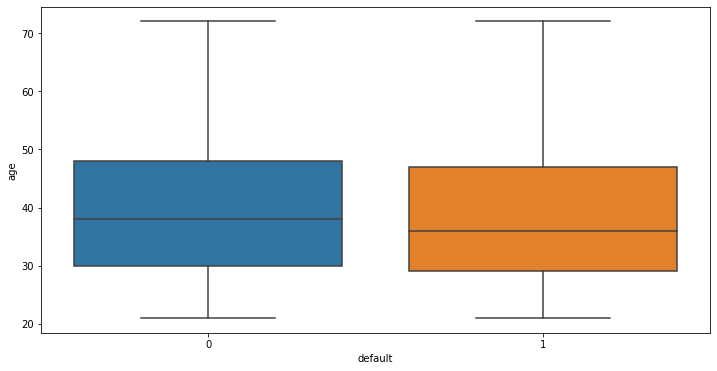

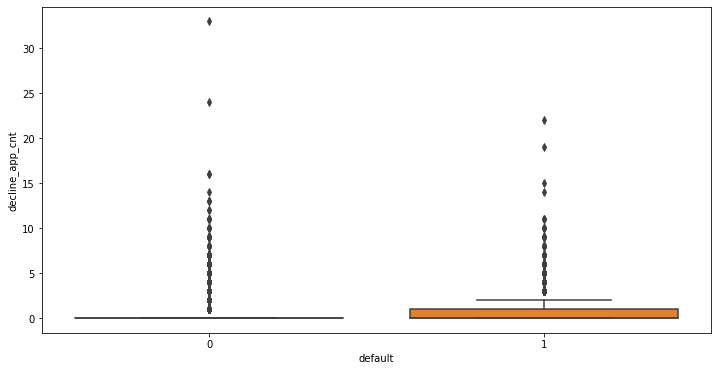

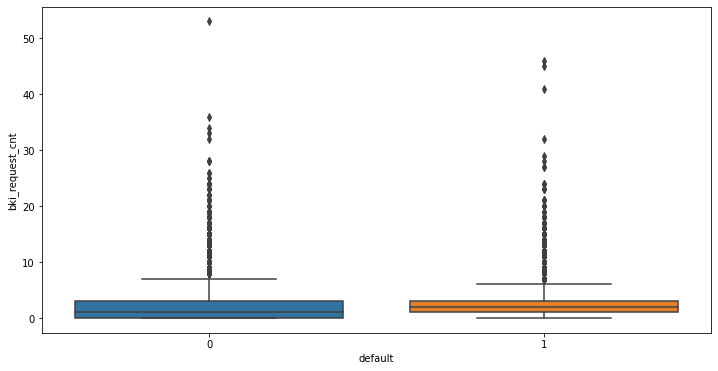

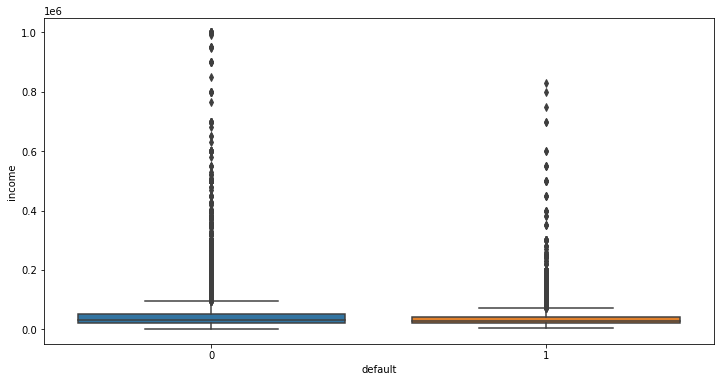

In [126]:
for col in num_cols:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=data, y=col, x='default')
    plt.show()

To proceed further it's important to look at the correlation of the features in the dataset. Strongly correlated features should be removed for further analysis. 

In [180]:
data.progress

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,25905,SCH,1,62,1,1,0,0,1,1,2,18000,0,0
1,63161,SCH,0,59,0,0,0,0,3,2,3,19000,0,0
2,25887,SCH,1,25,1,0,2,0,1,1,2,30000,1,0
3,16222,SCH,0,53,0,0,0,0,2,2,3,10000,0,0
4,101655,GRD,1,48,0,0,0,1,1,2,3,30000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73794,54887,GRD,0,45,0,0,0,0,3,1,2,17000,0,0
73795,76821,SCH,1,41,1,1,0,0,1,2,2,70000,0,0
73796,103695,SCH,1,31,0,0,0,0,4,2,3,45000,0,0
73797,861,SCH,0,29,0,0,0,1,3,1,3,13000,0,1


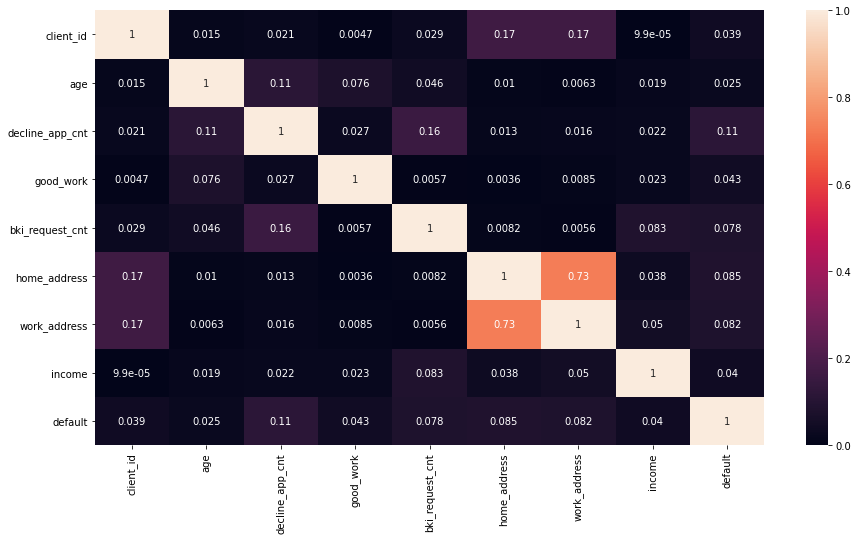

In [127]:
plt.figure(figsize=(15, 8));
sns.heatmap(data.corr().abs(), vmin=0, vmax=1, annot=True);

Here we see that the 'home_address' and 'work_address' features are highly correlated. It means that for futher analysis let's leave only one of them, e.g. 'home_address'.

Let's evaluate the importance of the numerical values by performing a univariate feature selection. Univariate feature selection works by selecting the best features based on univariate statistical tests. 

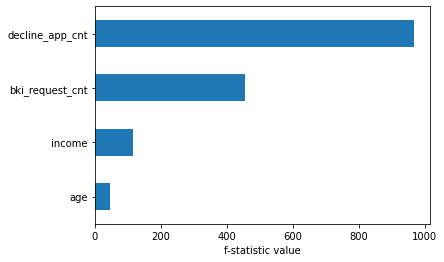

In [128]:
imp_num = pd.Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')
plt.xlabel('f-statistic value');

Features with higher f-statistic values are more significant for our linear model.

### Binary features

In [183]:
label_encoder = LabelEncoder()
mapped_education = pd.Series(label_encoder.fit_transform(data['sex']))
print(dict(enumerate(label_encoder.classes_)))

{0: 0, 1: 1}


In [184]:
# for binary features let's use LabelEncoders
for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])    
data.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,25905,SCH,1,62,1,1,0,0,1,1,2,18000,0,0
1,63161,SCH,0,59,0,0,0,0,3,2,3,19000,0,0
2,25887,SCH,1,25,1,0,2,0,1,1,2,30000,1,0
3,16222,SCH,0,53,0,0,0,0,2,2,3,10000,0,0
4,101655,GRD,1,48,0,0,0,1,1,2,3,30000,1,0


In [182]:
imp_cat = pd.Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

ValueError: could not convert string to float: 'SCH'

In [136]:
data_ready = pd.get_dummies(data, columns=cat_cols, )
data_ready.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   client_id         73799 non-null  int64
 1   sex               73799 non-null  int32
 2   age               73799 non-null  int64
 3   car               73799 non-null  int32
 4   car_type          73799 non-null  int32
 5   decline_app_cnt   73799 non-null  int64
 6   good_work         73799 non-null  int64
 7   bki_request_cnt   73799 non-null  int64
 8   income            73799 non-null  int64
 9   foreign_passport  73799 non-null  int32
 10  default           73799 non-null  int64
 11  education_ACD     73799 non-null  uint8
 12  education_GRD     73799 non-null  uint8
 13  education_PGR     73799 non-null  uint8
 14  education_SCH     73799 non-null  uint8
 15  education_UGR     73799 non-null  uint8
 16  home_address_1    73799 non-null  uint8
 17  home_address_2    73799 non-nul

In [142]:
X_cat = OneHotEncoder(sparse = False).fit_transform(data[cat_cols].values)
X_cat.shape[1]

11

In [144]:
data_ready[num_cols] = StandardScaler().fit_transform(data_ready[num_cols])

In [145]:
data_ready

,client_id,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,income,foreign_passport,...,education_GRD,education_PGR,education_SCH,education_UGR,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,work_address_3
0,25905,1,1.972115,1,1,-0.342858,0,-0.444189,-0.500363,0,...,0,0,1,0,1,0,0,0,1,0
1,63161,0,1.711705,0,0,-0.342858,0,0.443888,-0.478702,0,...,0,0,1,0,0,1,0,0,0,1
2,25887,1,-1.239607,1,0,2.143880,0,-0.444189,-0.240432,1,...,0,0,1,0,1,0,0,0,1,0
3,16222,0,1.190886,0,0,-0.342858,0,-0.000150,-0.673651,0,...,0,0,1,0,0,1,0,0,0,1
4,101655,1,0.756869,0,0,-0.342858,1,-0.444189,-0.240432,1,...,1,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73794,54887,0,0.496459,0,0,-0.342858,0,0.443888,-0.522024,0,...,1,0,0,0,1,0,0,0,1,0
73795,76821,1,0.149246,1,1,-0.342858,0,-0.444189,0.626007,0,...,0,0,1,0,0,1,0,0,1,0
73796,103695,1,-0.718787,0,0,-0.342858,0,0.887926,0.084483,0,...,0,0,1,0,0,1,0,0,0,1
73797,861,0,-0.892393,0,0,-0.342858,1,0.443888,-0.608668,0,...,0,0,1,0,1,0,0,0,0,1


In [150]:
X = data_ready.drop('default', axis=1).values
y = data_ready['default'].values

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [167]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]

fpr, tpr, threshold = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

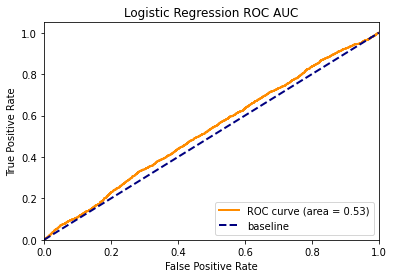

In [172]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='baseline')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC AUC')
plt.legend(loc="lower right")
plt.show()

In [173]:
from sklearn.model_selection import GridSearchCV

# add different types of regularization
penalty = ['l1', 'l2']

# add the ranges for C parameter
C = np.logspace(0, 4, 10)

# create a dict with hyperparameters
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Let's create a GridSearch with the 5-fold cv
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)
best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('best C:', best_model.best_estimator_.get_params()['C'])

c:\users\voytik\anaconda3\envs\ds\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\voytik\anaconda3\envs\ds\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\voytik\anaconda3\envs\ds\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\users\voytik\anaconda3\envs\ds\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\voytik\anaconda3\envs\ds

c:\users\voytik\anaconda3\envs\ds\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\voytik\anaconda3\envs\ds\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\voytik\anaconda3\envs\ds\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\users\voytik\anaconda3\envs\ds\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\voytik\anaconda3\envs\ds

c:\users\voytik\anaconda3\envs\ds\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\voytik\anaconda3\envs\ds\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\voytik\anaconda3\envs\ds\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\users\voytik\anaconda3\envs\ds\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\voytik\anaconda3\envs\ds

c:\users\voytik\anaconda3\envs\ds\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\voytik\anaconda3\envs\ds\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\voytik\anaconda3\envs\ds\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\users\voytik\anaconda3\envs\ds\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\voytik\anaconda3\envs\ds

c:\users\voytik\anaconda3\envs\ds\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\voytik\anaconda3\envs\ds\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\voytik\anaconda3\envs\ds\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\users\voytik\anaconda3\envs\ds\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\voytik\anaconda3\envs\ds

c:\users\voytik\anaconda3\envs\ds\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.87220312        nan 0.87220312        nan 0.87220312
        nan 0.87220312        nan 0.87220312        nan 0.87220312
        nan 0.87220312        nan 0.87220312        nan 0.87220312
        nan 0.87220312]
  warnings.warn(


best Penalty: l2
best C: 1.0


In [177]:
log_reg = LogisticRegressionCV(cv=5, random_state=0)
log_reg.fit(X_train, y_train)
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]

fpr, tpr, threshold = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

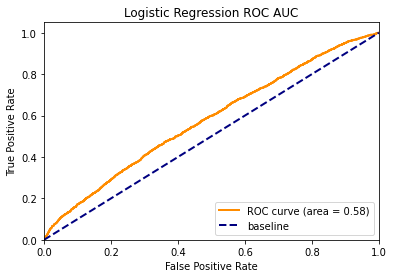

In [178]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='baseline')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC AUC')
plt.legend(loc="lower right")
plt.show()

In [179]:
log_reg.get_params()

{'Cs': 10,
 'class_weight': None,
 'cv': 5,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'l1_ratios': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 0,
 'refit': True,
 'scoring': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0}

In [185]:
data

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,25905,SCH,1,62,1,1,0,0,1,1,2,18000,0,0
1,63161,SCH,0,59,0,0,0,0,3,2,3,19000,0,0
2,25887,SCH,1,25,1,0,2,0,1,1,2,30000,1,0
3,16222,SCH,0,53,0,0,0,0,2,2,3,10000,0,0
4,101655,GRD,1,48,0,0,0,1,1,2,3,30000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73794,54887,GRD,0,45,0,0,0,0,3,1,2,17000,0,0
73795,76821,SCH,1,41,1,1,0,0,1,2,2,70000,0,0
73796,103695,SCH,1,31,0,0,0,0,4,2,3,45000,0,0
73797,861,SCH,0,29,0,0,0,1,3,1,3,13000,0,1
